## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from gammapy.data import DataStore
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import MapMaker
from gammapy.spectrum import (
    ReflectedRegionsBackgroundEstimator, 
    SpectrumExtraction,
    FluxPointsDataset,
    FluxPointsEstimator
)
from gammapy.modeling.models import PowerLaw
from gammapy.modeling import Datasets, Fit

import astropy.units as u
from regions import CircleSkyRegion
from astropy.coordinates import SkyCoord, Angle

In [2]:
!gammapy info


System:

	python_executable      : /Users/jer/anaconda/bin/python 
	python_version         : 3.6.8      
	machine                : x86_64     
	system                 : Darwin     


Gammapy package:

	path                   : /Users/jer/anaconda/lib/python3.6/site-packages/gammapy 
	version                : 0.13       


Other packages:

	numpy                  : 1.12.1     
	scipy                  : 0.19.1     
	matplotlib             : 3.1.0      
	cython                 : 0.25.2     
	astropy                : 2.0.12     
	astropy_healpix        : 0.2.1      
	reproject              : 0.3.1      
	sherpa                 : 4.9.0      
	pytest                 : 3.0.7      
	sphinx                 : 1.5.6      
	healpy                 : 1.10.3     
	regions                : 0.4        
	iminuit                : 1.3.6      
	naima                  : 0.8        
	uncertainties          : 3.0.1      


Gammapy environment variables:

	GAMMA_CAT              : /Users/jer/git/gammapy/gamma

## Select observations
### Catalog inspection

We can choose among four catalogs provided in the CTA 1DC
- agn
- egal
- gc
- gps

In [3]:
data_store = DataStore.from_dir("$CTADATA/index/gps")

In [4]:
data_store.info()

Data store:
HDU index table:
BASE_DIR: /Users/jer/DATA/DC/1dc/index/gps
Rows: 19620
OBS_ID: 110000 -- 113269
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']


Observation table:
Observatory name: 'N/A'
Number of observations: 3270



In [5]:
data_store.obs_table[:5]

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,OBJECT,CALDB,IRF,EVENTS_FILENAME,EVENT_COUNT
int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,bytes10,bytes8,bytes10,bytes8,int64,bytes21,bytes3,bytes13,bytes50,int64
110000,186.15609741,-64.019,300.0000158380702,-1.2999983233772607,0.0,90.0,0,1800.0,1764.0,0.98000001907,662774400.0,662776192.0,2021-01-01,11:58:51,2021-01-01,12:28:51,0,Galactic Plane Survey,1dc,South_z40_50h,1dc/1dc/data/baseline/gps/gps_baseline_110000.fits,107301
110001,186.15609741,-64.019,300.0000158380702,-1.2999983233772607,0.0,90.0,0,1800.0,1764.0,0.98000001907,662776320.0,662778112.0,2021-01-01,12:30:51,2021-01-01,13:00:51,0,Galactic Plane Survey,1dc,South_z40_50h,1dc/1dc/data/baseline/gps/gps_baseline_110001.fits,107374
110002,186.15609741,-64.019,300.0000158380702,-1.2999983233772607,0.0,90.0,0,1800.0,1764.0,0.98000001907,662778240.0,662780032.0,2021-01-01,13:02:51,2021-01-01,13:32:51,0,Galactic Plane Survey,1dc,South_z40_50h,1dc/1dc/data/baseline/gps/gps_baseline_110002.fits,107579
110003,186.15609741,-64.019,300.0000158380702,-1.2999983233772607,0.0,90.0,0,1800.0,1764.0,0.98000001907,662780160.0,662781952.0,2021-01-01,13:34:51,2021-01-01,14:04:51,0,Galactic Plane Survey,1dc,South_z40_50h,1dc/1dc/data/baseline/gps/gps_baseline_110003.fits,107224
110004,186.15609741,-64.019,300.0000158380702,-1.2999983233772607,0.0,90.0,0,1800.0,1764.0,0.98000001907,662782080.0,662783872.0,2021-01-01,14:06:51,2021-01-01,14:36:51,0,Galactic Plane Survey,1dc,South_z40_50h,1dc/1dc/data/baseline/gps/gps_baseline_110004.fits,107052


### Pointings and Target

We will point to a specific target with galactic coordinates (40.2, -1.5) 

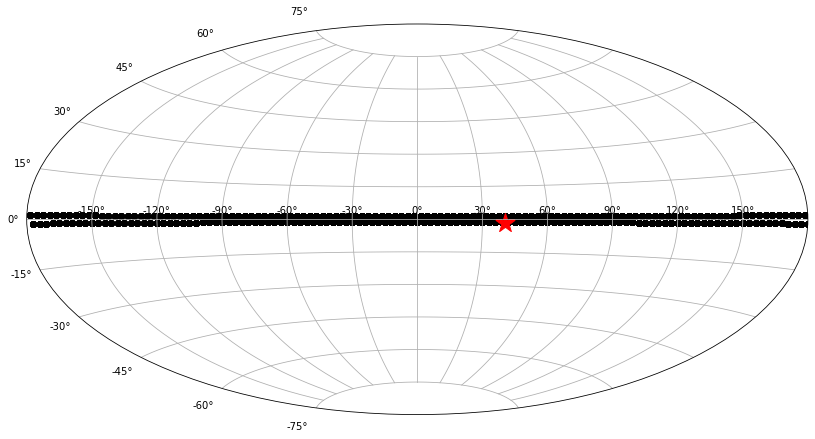

In [6]:
# Pointing positions
all_pointings = SkyCoord(data_store.obs_table['GLON_PNT'], data_store.obs_table['GLAT_PNT'], frame='galactic', unit='deg')  

# Plot pointings
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection="aitoff")
ax.scatter(
    all_pointings.l.wrap_at("180 deg").radian,
    all_pointings.b.wrap_at("180 deg").radian,
    color="k",
)
ax.grid(True)

#
#
# We define our selected position here !!! <---------------------------------
pos_target =  SkyCoord(40.2, -1.5, frame='galactic', unit='deg')

# Plot target
ax.scatter(
    pos_target.l.wrap_at("180 deg").radian, pos_target.b.radian, marker="*", s=400, c="red"
)

### Filter the observations

These observations have max **events offsets** of nearly 5 deg.

In [7]:
ob = data_store.obs(data_store.obs_table[1]['OBS_ID'])
ob.events.offset.max()

<Angle 4.999997 deg>

Let's filter observations taken in a radius of 2 deg of our target 

In [8]:
offset = pos_target.separation(all_pointings).deg
mask = offset < 1.5 # This is a True, False, True, False,... boolean mask 
table_selected = data_store.obs_table[mask]
table_selected

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,OBJECT,CALDB,IRF,EVENTS_FILENAME,EVENT_COUNT
int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,bytes10,bytes8,bytes10,bytes8,int64,bytes21,bytes3,bytes13,bytes50,int64
110627,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665625600.0,665627392.0,2021-02-03,11:58:51,2021-02-03,12:28:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110627.fits,100730
110628,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665627520.0,665629312.0,2021-02-03,12:30:51,2021-02-03,13:00:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110628.fits,100439
110629,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665629440.0,665631232.0,2021-02-03,13:02:51,2021-02-03,13:32:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110629.fits,100633
110630,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665631360.0,665633152.0,2021-02-03,13:34:51,2021-02-03,14:04:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110630.fits,100983
110631,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665633280.0,665635072.0,2021-02-03,14:06:51,2021-02-03,14:36:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110631.fits,100804
110632,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665635200.0,665636992.0,2021-02-03,14:38:51,2021-02-03,15:08:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110632.fits,100940
110633,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665637120.0,665638912.0,2021-02-03,15:10:51,2021-02-03,15:40:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110633.fits,100734
110634,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665639040.0,665640832.0,2021-02-03,15:42:51,2021-02-03,16:12:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110634.fits,100690
110635,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665640960.0,665642752.0,2021-02-03,16:14:51,2021-02-03,16:44:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110635.fits,101152


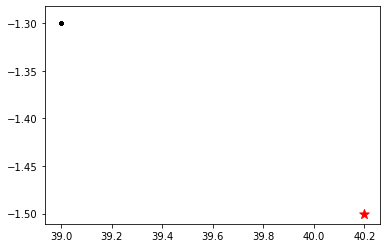

In [9]:
# Pointing positions
sel_pointings = SkyCoord(table_selected['GLON_PNT'], table_selected['GLAT_PNT'], frame='galactic', unit='deg')  

# Plot pointings
plt.scatter(
    sel_pointings.l,
    sel_pointings.b,
    color="k",
    s=10
)
ax.grid(True)

# Plot target
plt.scatter(
    pos_target.l, pos_target.b, marker="*", s=100, c="red"
)

## Make sky images

Let's havea look at the events of the first observation

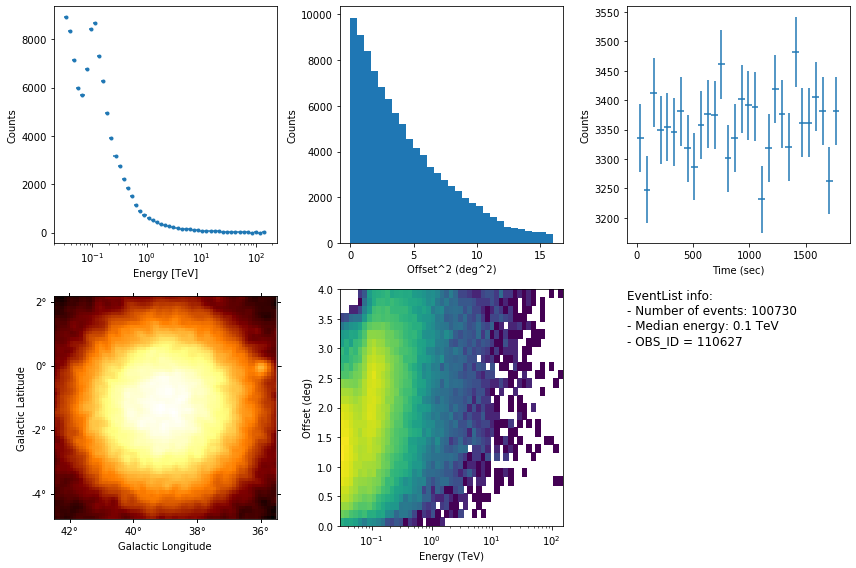

In [10]:
observations_selected = data_store.get_observations(table_selected['OBS_ID'])
events = observations_selected[0].events
events.peek()

There are about 100 000 events for a single observation, energy ranging from 1e-2 to 100 Tev.

In [11]:
energy_axis = MapAxis.from_edges(
    np.logspace(-1., 1., 10), unit="TeV", name="energy", interp="log"
)

In [12]:
geom = WcsGeom.create(
    skydir=pos_target,
    binsz=0.02,
    width=(5, 5),
    coordsys="GAL",
    proj="TAN",
    axes=[energy_axis],
)

In [13]:
%%time
maker = MapMaker(geom, offset_max="2.5 deg")
maps = maker.run(observations_selected)
images = maker.run_images()

CPU times: user 40.1 s, sys: 5.08 s, total: 45.1 s
Wall time: 47.7 s


In [14]:
maps.keys()

dict_keys(['counts', 'exposure', 'background'])

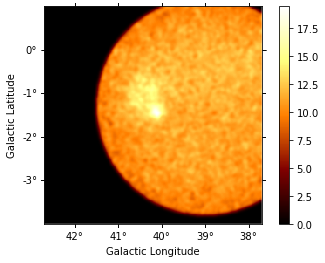

In [15]:
images["counts"].smooth(2).plot(add_cbar=True);

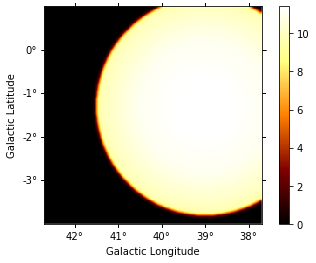

In [16]:
images["background"].smooth(2).plot(add_cbar=True);

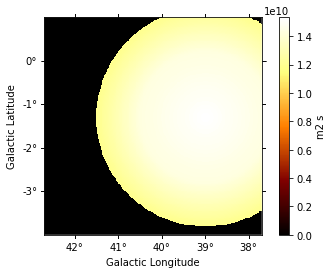

In [17]:
images["exposure"].plot(add_cbar=True);

In [18]:
excess = images["counts"].copy()
excess.data -= images["background"].data
images["excess"] = excess

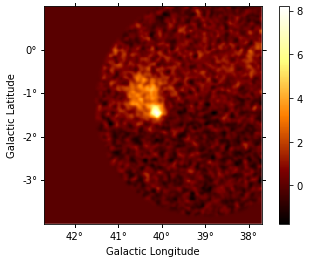

In [19]:
images["excess"].smooth(2).plot(add_cbar=True);

In [20]:
pos_target

<SkyCoord (Galactic): (l, b) in deg
    (40.2, -1.5)>

## Define on region

The next step is to define a signal extraction region around our target position, also known as on region.

In [21]:
on_region_radius = Angle("0.2 deg")
on_region = CircleSkyRegion(center=pos_target, radius=on_region_radius)

## Create exclusion mask

We will use the reflected regions method to place off regions to estimate the background level in the on region. To make sure the off regions don’t contain gamma-ray emission, we create an exclusion mask.

(<Figure size 432x288 with 1 Axes>,
 None)

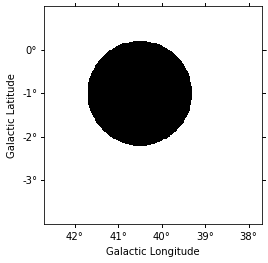

In [22]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(40.5, -1, unit="deg", frame="galactic"),
    radius=1.2 * u.deg,
)

skydir = pos_target.galactic
exclusion_mask = Map.create(
    npix=(250, 250), binsz=0.02, skydir=skydir, proj="TAN", coordsys="GAL"
)

mask = exclusion_mask.geom.region_mask([exclusion_region], inside=False)
exclusion_mask.data = mask
exclusion_mask.plot()

## Estimate background

Next we will manually perform a background estimate by placing reflected regions around the pointing positions and looking at the source statistics. This will result in a `gammapy.background.BackgroundEstimate` list that serves as input for other classes in gammapy.

In [23]:
%%time
background_estimator = ReflectedRegionsBackgroundEstimator(
    observations=observations_selected, on_region=on_region, exclusion_mask=exclusion_mask
)

background_estimator.run()

CPU times: user 18.4 s, sys: 790 ms, total: 19.2 s
Wall time: 22 s


<Figure size 576x576 with 0 Axes>

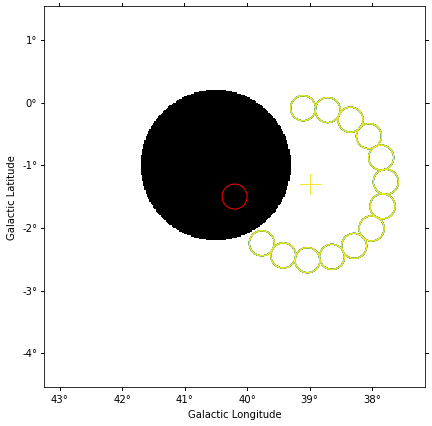

In [24]:
plt.figure(figsize=(8, 8))
background_estimator.plot();

## Extract spectrum

In [25]:
e_reco = MapAxis.from_edges(
    np.logspace(-1., 1., 10), unit="TeV", name="e_reco", interp="log"
).center
e_true = MapAxis.from_edges(
    np.logspace(-1., 1., 10), unit="TeV", name="e_true", interp="log"
).center

In [26]:
extraction = SpectrumExtraction(
    observations=observations_selected,
    bkg_estimate=background_estimator.result,
    containment_correction=False,
    use_recommended_erange=False,
    e_reco=e_reco,
    e_true=e_true
)
extraction.run()
spec_observations = extraction.spectrum_observations

## Fit spectrum

In [27]:
%%time
model = PowerLaw()
for obs in spec_observations:
    obs.model = model
fit = Fit(spec_observations)
res = fit.run()
print(res)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 37
	total stat : 161.29

CPU times: user 1.26 s, sys: 21.7 ms, total: 1.28 s
Wall time: 1.55 s


In [28]:
print(res.parameters)

Parameters

	index                   : 2.138  
	amplitude               : 8.10e-13  1 / (cm2 s TeV)
	reference    (frozen)   : 1.000  TeV



## Compute Flux Points

In [29]:
stacked = Datasets(spec_observations).stack_reduce()
flux_model = model.copy()
flux_model.parameters.covariance = res.parameters.covariance
stacked.model = flux_model

e_edges = np.logspace(-1, 1, 16) * u.TeV
flux_point_estimator = FluxPointsEstimator(
    e_edges=e_edges, datasets=stacked
)

In [30]:
fp = flux_point_estimator.run()
fp.table["is_ul"] = fp.table["ts"] < 4
flux_points_dataset = FluxPointsDataset(data=fp, model=flux_model)

In [31]:
flux_points_dataset.data.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,loglike,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],dloglike_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn,is_ul
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
0.167,0.129,0.215,3.730e-11,3.229e-12,5.312e-13,1.038e-12,0.777,0.000,0.177,1440,0.179,0.176,1.137,4.543,20.643,0.200 .. 5.000,11.169880680390634 .. 413.5581260912586,2.899e-11,4.243e-11,6.614e-12,6.665e-12,6.564e-12,False
0.278,0.215,0.359,1.249e-11,1.804e-12,4.949e-13,9.671e-13,0.918,0.000,0.140,817,0.141,0.139,1.204,7.070,49.981,0.200 .. 5.000,29.521451318723848 .. 529.8463436101156,1.147e-11,1.504e-11,1.750e-12,1.766e-12,1.733e-12,False
0.464,0.359,0.599,4.182e-12,1.007e-12,4.611e-13,9.010e-13,1.009,0.000,0.131,492,0.133,0.130,1.279,8.685,75.423,0.200 .. 5.000,45.95658180740429 .. 510.4500636985176,4.221e-12,5.350e-12,5.491e-13,5.566e-13,5.416e-13,False
0.774,0.599,1.000,1.400e-12,5.627e-13,4.297e-13,8.395e-13,1.216,0.000,0.133,309,0.135,0.131,1.491,11.228,126.057,0.200 .. 5.000,81.127322167089 .. 412.8711618314446,1.703e-12,2.088e-12,1.861e-13,1.894e-13,1.828e-13,False
1.292,1.000,1.668,4.689e-13,3.143e-13,4.003e-13,7.822e-13,1.055,0.000,0.125,188,0.127,0.123,1.317,10.964,120.215,0.200 .. 5.000,69.68965961549839 .. 422.88608716496674,4.950e-13,6.174e-13,5.859e-14,5.970e-14,5.747e-14,False
2.154,1.668,2.783,1.570e-13,1.756e-13,3.730e-13,7.288e-13,1.074,0.000,0.118,160,0.121,0.115,1.322,12.697,161.217,0.200 .. 5.000,90.161790455134 .. 433.3773370342278,1.686e-13,2.075e-13,1.855e-14,1.897e-14,1.813e-14,False
3.594,2.783,4.642,5.258e-14,9.806e-14,3.476e-13,6.791e-13,0.981,0.000,0.119,109,0.123,0.116,1.235,12.202,148.889,0.200 .. 5.000,75.04026375212288 .. 392.0118198899445,5.158e-14,6.494e-14,6.278e-15,6.476e-15,6.084e-15,False
5.995,4.642,7.743,1.761e-14,5.477e-14,3.238e-13,6.327e-13,0.802,0.000,0.135,65,0.140,0.130,1.095,8.434,71.127,0.200 .. 5.000,31.76133358285324 .. 298.9963714019509,1.413e-14,1.927e-14,2.377e-15,2.473e-15,2.284e-15,False


(<matplotlib.axes._subplots.AxesSubplot at 0x1151eaef0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x115530b00>)

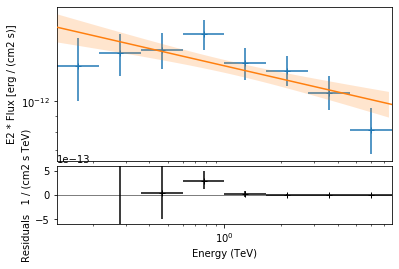

In [32]:
flux_points_dataset.peek()